# Practice Lecture 14: Unsupervised Learning
In this lab we will look at unsupervised learning methods for classification and regression. \
Based on Chapter 9 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice14-UnsupervisedLearning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
sklearn.set_config(print_changed_only=False)

## Exercise 1: clustering
For the dataset below, use sklearn k-means and plot how it evolves with iterations 1 and 5.\
Use the example on the notebook to write your 2x2 plot.\
Visualize the movement of the centroids on the left column and the boundaries on the right column

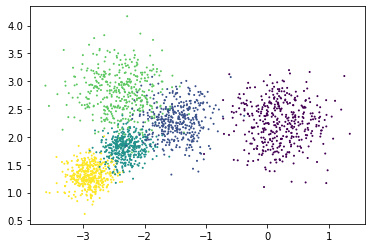

In [3]:
from sklearn.datasets import make_blobs
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.3,  1.8],
     [-2.4,  2.8],
     [-2.9,  1.3]])
blob_std = np.array([0.4, 0.3, 0.2, 0.4, 0.2])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=1);

To do unsupervised clustering we need to work without labels (without y)

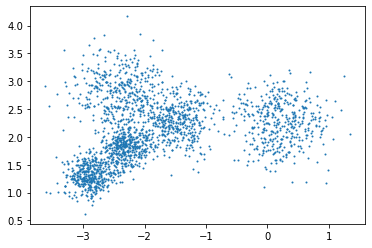

In [4]:
#let us remove the labels to do unsupervised clustering
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=None, s=1);

The fit method will calculate the centroids and labels, which we can access throught the kmeans variables.\
The predict method in "fit_predict" just gives us the same information and the labels_ variable.

In [5]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
print('X shape', X.shape)
print('y_pred shape', y_pred.shape)
print('labels',kmeans.labels_)
print('y_pred', y_pred)
print('centers', kmeans.cluster_centers_)

X shape (2000, 2)
y_pred shape (2000,)
labels [0 4 2 ... 3 2 4]
y_pred [0 4 2 ... 3 2 4]
centers [[-2.89479755  1.307358  ]
 [-1.4434708   2.30795331]
 [ 0.21291772  2.25399958]
 [-2.43742863  2.89912413]
 [-2.29781832  1.856693  ]]


In [6]:
kmeans.labels_ is y_pred

True

In [7]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([2, 2, 3, 3], dtype=int32)

Let us define a few plotting functions that we will need: 
1) plot data
2) plot centroids
3) plot decision boundaries

Functions 1 and 2 are used in 3.

In [23]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=10, linewidths=10, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=10, linewidths=15, color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

To illustrate the changes with iterations, we will use two clusters with 1 and 5 iterations.\
(the choice 1 to 5 is just to make changes more obvious, you can use 1 and 2 to see how much change occurs in 1 iteration).

In [13]:
kmeans_iter1 = KMeans(n_clusters=5,init="random", n_init=1, algorithm="lloyd", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5,init="random", n_init=1, algorithm="lloyd", max_iter=5, random_state=1)

print(kmeans_iter1.fit(X))
print(kmeans_iter2.fit(X))

KMeans(algorithm='lloyd', copy_x=True, init='random', max_iter=1, n_clusters=5,
       n_init=1, random_state=1, tol=0.0001, verbose=0)
KMeans(algorithm='lloyd', copy_x=True, init='random', max_iter=5, n_clusters=5,
       n_init=1, random_state=1, tol=0.0001, verbose=0)


kmeans works by iterating through two key steps: 
1) assign centroids,
2) assign labels. 

Each depends on the other, so we have to freeze one of them at each step and update the other. 

### Plotting steps
The following plots plots illustrate how the kmeans algorithm work. 
- initial cluster centers (random initialization)
- calculate the distance between each sample and the centroids, assign the labels (and boundaries).
- with the assigned labels calculate new centroids. 
- with the new centroids calculate the new labels.

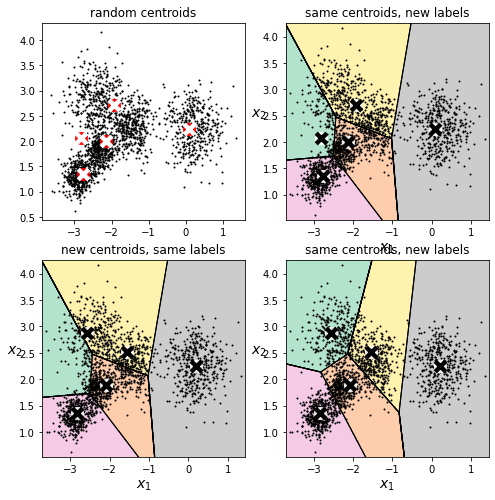

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.title('random centroids')
plt.subplot(222)
plot_decision_boundaries(kmeans_iter1, X)
plt.title('same centroids, new labels')
plt.subplot(223)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False)
plot_centroids(kmeans_iter2.cluster_centers_)
plt.title('new centroids, same labels')
plt.subplot(224)
plot_decision_boundaries(kmeans_iter2, X)
plt.title('same centroids, new labels');

## Exercise 2: Cluster best models
Create clusters with different parameters and estimate their quality by using inertia.\
First try using different number of clusters.\
Then do the same with the different initialization parameters.

In [26]:
kmeans_v1 = KMeans(n_clusters=4, init="random", n_init=1, algorithm="lloyd", random_state=42)
kmeans_v2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="lloyd", random_state=42)
kmeans_v3 = KMeans(n_clusters=6, init="random", n_init=1, algorithm="lloyd", random_state=42)
kmeans_v1.fit(X)
kmeans_v2.fit(X)
kmeans_v3.fit(X)

KMeans(algorithm='lloyd', copy_x=True, init='random', max_iter=300,
       n_clusters=6, n_init=1, random_state=42, tol=0.0001, verbose=0)

In [27]:
print(kmeans_v1.inertia_)
print(kmeans_v2.inertia_)
print(kmeans_v3.inertia_)

452.38281353448673
333.3354079442936
291.1302957760049


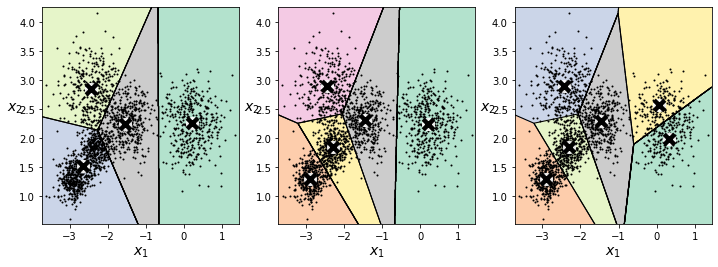

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plot_decision_boundaries(kmeans_v1, X)
plt.subplot(132)
plot_decision_boundaries(kmeans_v2, X)
plt.subplot(133)
plot_decision_boundaries(kmeans_v3, X)


Another way to test, we can create several clusters and plot their inertia

In [29]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

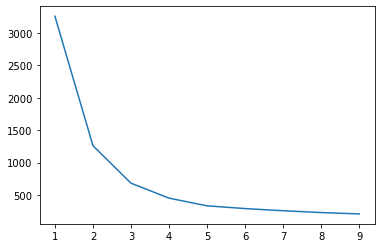

In [30]:
k=np.arange(1,10)
plt.plot(k,inertias);

The inertia decays as we have more clusters, so it needs to be taken into account.\
The following metric is more accurate and clearly shows the decay of quality with larger clusters.\
Although it fails to notice superiority of k=5 over 4. An alternative is to use the silhouette coefficient.

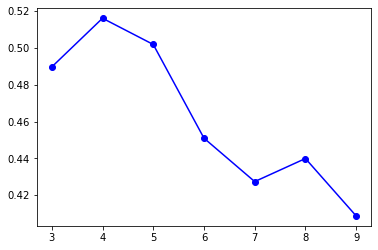

In [31]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[2:]]
plt.plot(range(3, 10), silhouette_scores, "bo-");

Let us try now different initializations. Please try your own combinations until getting the smallest possible inertia.
NOTE: The default initialization "k-means++" assigns preference to centroids that are far from the already selected centroids.

In [33]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans_v1 = KMeans(n_clusters=5, init="random")
kmeans_v2 = KMeans(n_clusters=5, init=good_init, n_init=1,algorithm="lloyd")
kmeans_v3 = KMeans(n_clusters=5, init="k-means++", n_init=10, random_state=42)


print(kmeans_v1.fit(X))
print(kmeans_v2.fit(X))
print(kmeans_v3.fit(X))

KMeans(algorithm='lloyd', copy_x=True, init='random', max_iter=300,
       n_clusters=5, n_init=10, random_state=None, tol=0.0001, verbose=0)
KMeans(algorithm='lloyd', copy_x=True,
       init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       max_iter=300, n_clusters=5, n_init=1, random_state=None, tol=0.0001,
       verbose=0)
KMeans(algorithm='lloyd', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, random_state=42, tol=0.0001, verbose=0)


In [34]:
print(kmeans_v1.inertia_)
print(kmeans_v2.inertia_)
print(kmeans_v3.inertia_)

333.3312724282323
333.33484239300407
333.3310592311876


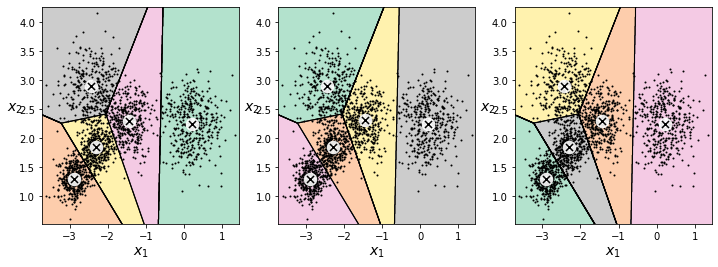

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plot_decision_boundaries(kmeans_v1, X)
plt.subplot(132)
plot_decision_boundaries(kmeans_v2, X)
plt.subplot(133)
plot_decision_boundaries(kmeans_v3, X)

The algorithm parameter permits to define a faster algorithm like Elkhan

In [36]:
%timeit -n 10 KMeans(algorithm="lloyd").fit(X)

82.1 ms ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit -n 10 KMeans(algorithm="elkan").fit(X)

114 ms ± 9.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Exercise 3: Irregular clusters 
For the data below, try to fit a cluster without initial centers then giving the centers given below.

before rotation [1.02406253 0.59252695]
after rotation [0.81672911 1.32719052]


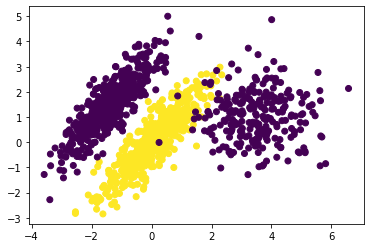

In [38]:
good_init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]])
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
print('before rotation',X1[0])
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
print('after rotation',X1[0])
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
plt.scatter(X1[:,0],X1[:,1],c=y1)
plt.scatter(X2[:,0],X2[:,1],c=y2)

In [39]:
kmeans_good = KMeans(n_clusters=3, init=good_init, n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='lloyd', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, random_state=42, tol=0.0001, verbose=0)

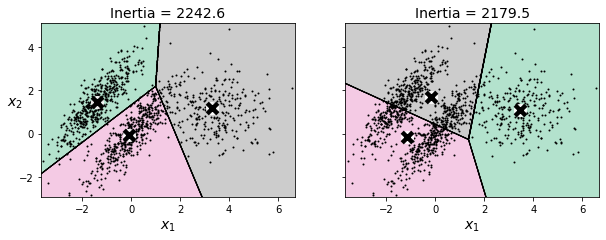

In [40]:
plt.figure(figsize=(10, 3.2))
plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)
plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14);


## Exercise 4: Gaussian mixture model
Using a Gaussian mixture model to separate the Iris dataset. Visually compare the predicted labels to the original labels.

In [41]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target

In [42]:
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(n_components=3)
gm.fit(X) # notice we are not using y (it would supervised if we did)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [43]:
y_pred=gm.predict(X)
print(y_pred.shape)
print(X.shape)
print(data.target_names)
print(data.feature_names)

(150,)
(150, 4)
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [44]:
print(y_pred[:150])
print(y[:150])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Text(0.5, 1.0, 'Predicted')

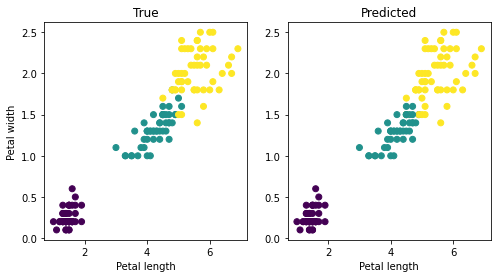

In [45]:
plt.figure(figsize=(8,4))
plt.subplot(121);plt.scatter(X[:,2],X[:,3],c=y)
plt.xlabel("Petal length");plt.ylabel("Petal width")
plt.title("True")
plt.subplot(122);plt.scatter(X[:,2],X[:,3],c=y_pred)
plt.xlabel("Petal length")
plt.title("Predicted")


## Exercise 5: Gaussian Mixture Model for bloobs with different shapes
Use a Gaussian mixture model to classify the moons data set with the parameters below.\
Check the model has converged and in how many iterations. Plot the decision boundaries. 



We will make the problem harder by making elongated and circular blobs on top of each other. \
Let us build the model step by step for illustration.

the program produces labels which we will not use y[:15]= [1 1 0 1 0 0 1 0 0 1 0 1 1 1 1]


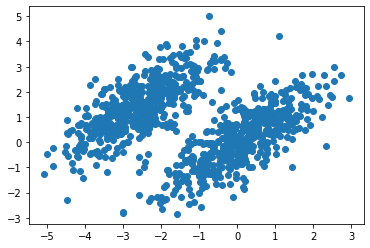

In [46]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
# let us make the blobs elongated by projecting them along a given matrix
mapmatrix=np.array([[0.274, 0.95], [0.932, 0.598]])
X1 = X1.dot(mapmatrix)
plt.figure()
plt.scatter(X1[:,0],X1[:,1])
print('the program produces labels which we will not use y[:15]=',y1[:15])

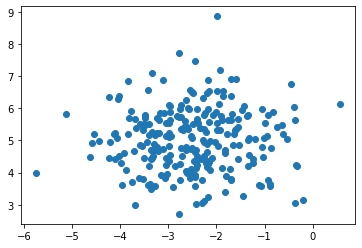

In [47]:
# let us make a third blob
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
# shift down by -8 to center it with the others
X2 = X2 + [0, -4]
y2 = y2 + 2; # need to shift to 2 because there are already 2 clusters.
plt.figure()
plt.scatter(X2[:,0],X2[:,1])

Now combine all together. We need to concatenate (by rows).

(1000, 2)
(250, 2)
(1250, 2) (1250,)


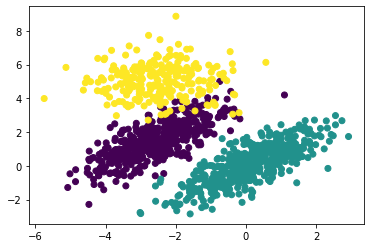

In [48]:
print(X1.shape)
print(X2.shape)
X = np.r_[X1, X2]
y = np.r_[y1, y2]
print(X.shape,y.shape)
plt.figure()
plt.scatter(X[:,0],X[:,1],c=y)

Now we are ready to try unsupervised ML classification (we won't use the labels)

In [49]:
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(n_components=3)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture class calculates the weights, means and variances for the Gaussian distributions.\
The weights assign relative importance to the 3 distributions. \
Notice from the covariances: 2 distributions are elongated along the right diagonal, the remaining distributions is circular
### Questions:
Could you tell which one is circular?
Also, can you tell why we have weights of around 40%, 40%, 20%?

In [50]:
print('weights=',gm.weights_)
print('\n')
print('means=\n',gm.means_)
print('\n')
print('covariances=\n',gm.covariances_)

weights= [0.38118729 0.39961172 0.21920099]


means=
 [[-2.64392273  1.34489622]
 [ 0.09062645  0.10530045]
 [-2.42882981  4.87067257]]


covariances=
 [[[ 0.86669428  0.69475643]
  [ 0.69475643  1.0316092 ]]

 [[ 1.01952834  0.86804627]
  [ 0.86804627  1.23889733]]

 [[ 1.04792731 -0.07962194]
  [-0.07962194  1.19236903]]]


In [51]:
print('mapping matrix used to build the two elongated blobs\n\n',mapmatrix[:,:])

mapping matrix used to build the two elongated blobs

 [[0.274 0.95 ]
 [0.932 0.598]]


Let us predict the classes for the given values and compare with the true values.

converged? True
how many iterations? 5


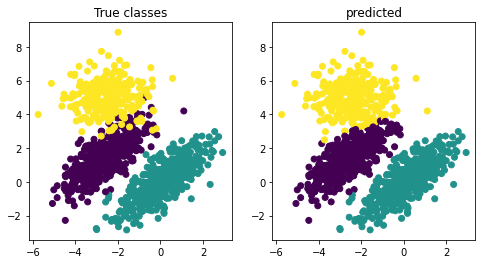

In [52]:
y_pred=gm.predict(X)
plt.figure(figsize=(8,4))
plt.subplot(121);plt.scatter(X[:,0],X[:,1],c=y);plt.title('True classes')
plt.subplot(122);plt.scatter(X[:,0],X[:,1],c=y_pred);plt.title('predicted')
print('converged?',gm.converged_)
print('how many iterations?',gm.n_iter_)

Let us now classify a new sample

In [53]:
Xnew=np.array([0,0]).reshape(1,-1)
print('class',gm.predict(Xnew))
print('probabilities',gm.predict_proba(Xnew))

class [1]
probabilities [[6.11643713e-08 9.99997917e-01 2.02135769e-06]]


We can get the PDF (probability density function) 

In [54]:
np.exp(gm.score_samples(Xnew))

array([0.08866597])

As described in the theory, integrating the PDF over all the data space will give us the full probability

In [55]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999997046522556

Let us generate a meshgrid to plot the decision boundaries.

In [56]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    # gmm.score_samples: Compute the weighted log probabilities for each sample.
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    

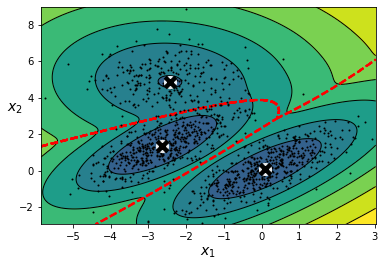

In [57]:
plot_gaussian_mixture(gm,X)

## Exercise 6: Bayesian Gaussian Mixture model
Use Bayesian Gaussian Mixture to estimate the optimal number of clusters in the data set below.\
Plot the boundaries and examine the weights. Experiment with different number of clusters.\
Try full, spherical, tied and diag
### Question:
If you had to do an analogy with classical regularization, what model norm would you say the inversion is using? 



(1250, 2)


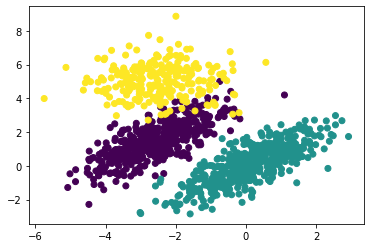

In [58]:
#X, y = make_blobs(n_samples=1000, centers=((4, -4), (0, 0), (3,3), (1,-1)), random_state=42)
print(X.shape)
plt.figure()
plt.scatter(X[:,0],X[:,1],c=y)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')
number of iterations 101
weight for the 10 components [0.4  0.   0.39 0.21 0.   0.   0.   0.   0.   0.  ]


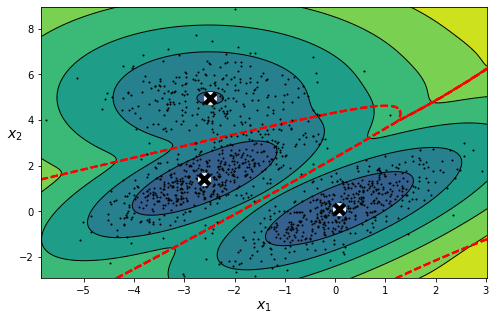

In [59]:

from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, max_iter=1000, covariance_type='full')
print(bgm.fit(X))
print('number of iterations',bgm.n_iter_)
print('weight for the 10 components',np.round(bgm.weights_,2))
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

The Bayesian algorithm is behaving as a $\ell_1$ model norm regularization, also known as minimum entropy in the Bayes context.\
Entropy is a minimum when the model coefficients are as few as possible, that is information is localized

## dbscan

In [61]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
from sklearn.cluster import DBSCAN

In [62]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)
DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)


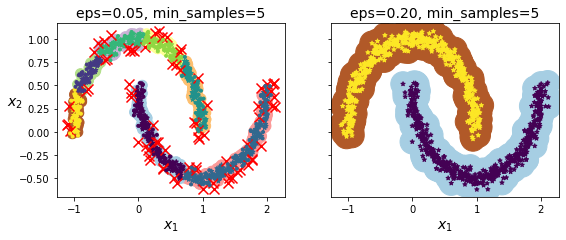

In [63]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
print(dbscan.fit(X))
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
print(dbscan2.fit(X))

plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)
plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)
plt.show()